Below is an abriged version of the script I made for the client. It takes in a crm spreadsheet that ranks companies as good fits or not, webscrapes the companies websites looking for key chosen terms, and then uses the found data to predict the quality of the companies.

In [48]:
#Imports
import pandas as pd
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager as CM
import time
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from inspect import signature
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier
import numpy as np

In [49]:
#Load the labeled data, company names, websites, and their ranking. This data is not the original data, and has been randomized.
train_df = pd.read_csv("sample_training_full.csv")
print('Total number of companies in training data: ' + str(len(train_df)))
print(train_df.describe())

Total number of companies in training data: 5074
       description   staffCount  yearFounded        inCRM  StronginCRM
count          0.0  5074.000000  4347.000000  5074.000000  5074.000000
mean           NaN    63.441860  2011.687601     0.066417     0.025818
std            NaN   279.474643    32.607053     0.249034     0.158607
min            NaN     4.000000     1.000000     0.000000     0.000000
25%            NaN    13.000000  2011.000000     0.000000     0.000000
50%            NaN    20.000000  2015.000000     0.000000     0.000000
75%            NaN    40.000000  2018.000000     0.000000     0.000000
max            NaN  7731.000000  2021.000000     1.000000     1.000000


In [51]:
#Webscrape the 'description' from their website
from webscraper_tools import relevant_terms, link_terms, most_relevant_terms, get_relevant_elements_soup, get_relevant_image_links_soup

share_details = False

options = webdriver.ChromeOptions()
driver = webdriver.Chrome(options=options,  executable_path=CM().install())
start = time.time()

#Reset global failure count (a way of seeing if it's broken)
global_failure_count = 0

#Cumulative counts for diagnostics
diagnostic_failure_count = 0
diagnostic_restart_count = 0
diagnostic_file_count = 0

#Iterate through the whole dataframe with the company names and urls
for index, row in train_df.iterrows():
    #Progress monitor time start
    company_start_time = time.time()
    
    #Get the url and company name from the correct row
    company_url = row['website']
    company = row['companyName']

    
    
    timestamp = time.strftime('%Y%m%d%H%M%S')
    
    #Progress useful info
    if share_details:
        print(f' - COMPANY {index + 1}: {company} -')
    
    #This will aid us in determining if the program has gone completely wrong
    failure_count = 0
    
    #if three first websites have failed in a row, restart the browser and add to diagnostic stats
    if global_failure_count >= 3:
        driver = webdriver.Chrome(executable_path = driver_path) 
        driver.set_page_load_timeout(30)
        diagnostic_restart_count = diagnostic_restart_count + 1
    
    #Progress useful info
    print(f' ~ Level 0 ~')
    
    #Open the company website. If it doesn't work, wait one second and try again.
    try:
        driver.get(company_url)
        global_failure_count = 0
    except:
        time.sleep(1)
        try:
            driver.get(company_url)
        except:
            
            #Count failures; if the company as a whole gets up to 8, it gets logged as a failure and we give up.
            if share_details:
                print('failure 0: {}'.format(company_url))
            global_failure_count = global_failure_count + 1
            failure_count = failure_count + 1
            #This company has already failed, actually...
            #Skip to next company
            continue
                
    #Get a BeautifulSoup version of the page
    try:
        html_source = driver.page_source
    except:
        html_source = ''
    soup = BeautifulSoup(html_source, 'html.parser')
        
    #Get all the relevant elements on the page
    relements = get_relevant_elements_soup(relevant_terms,link_terms,soup)
    
    #This list will contain all of our output text.
    relevant_text = []
    
    #This list will contain all of the relevant link elements (not URLs) we find on the first level of webpages.
    relevant_links = []
    
    #For every relevant element on the page, check if it's a link.
    for relement in relements:
        if relement is None:
            break
        if relement.name == 'a': ###########################################################
            #If it is a link, add it to the relevant link list.
            relevant_links.append(relement)
        
        #Whether or not it's a link, add the text of the element's parent to the main text output list.
        parent = relement.parent
        try:
            relevant_text.append(parent.get_text())
        except:
            pass
    
    #This list will hold all the URLs from the links we just collected.
    relevant_urls = []
    
    #For every one of the links we collected, get the URL it leads to and add it to the list.
    for relevant_link in relevant_links:
        url = relevant_link.get('href')
        if url is None:
            continue
        #Make sure we're not opening any emails or PDFs; we just want webpages.
        if 'mailto' in url or '.pdf' in url or 'javascript' in url or 'archive.org' in url:
            pass
        else:
            relevant_urls.append(url)
        
    #Check if there are any image links we should care about
    relevant_image_urls = get_relevant_image_links_soup(relevant_terms,soup)
    
    #Add any urls from image links to the 
    relevant_urls = relevant_urls + relevant_image_urls
    
    #Remove any duplicates from the list of relevant urls. Switching from list to set and back because order doesn't matter
    relevant_urls = list(set(relevant_urls))
            
    #This will hold all the URLs we collect from that
    relevant_urls_2 = []

    #Progress useful info
    if share_details:
        print(f' ~ Level 1 ~')
    
    #Go through all the first list of relevant urls one by one
    for relevant_url in relevant_urls:
        
        #If it's failed too many times, just give up
        if failure_count > 8:
            continue
        
        #Otherwise, grab the url. If it fails, wait one second and try again
        try:
            driver.get(relevant_url)
            
            #Temporary print for debugging
            if share_details:
                print(relevant_url)
            
            #Reset failure counter
            failure_count = 0
        except:
            try:
                if relevant_url[0] == '/':
                    relevant_url = f'{company_url}{relevant_url}'
                    if share_details:
                        print('concat')
                time.sleep(1)
                driver.get(relevant_url)
                if share_details:
                    print(relevant_url)
            #If it fails again, report it and count this as a failure.
            except:
                if share_details:
                    print('failure 1: {}'.format(relevant_url))
                failure_count = failure_count + 1

        #Get a BeautifulSoup version of the page
        try:
            html_source = driver.page_source
        except:
            html_source = ''
        soup2 = BeautifulSoup(html_source, 'html.parser')
                
        #On each page, grab all the relevant elements
        relements2 = get_relevant_elements_soup(relevant_terms, link_terms, soup2)
                                           
        #Process each of the relevant elements on the page
        for relement2 in relements2:
            if relement2 is None:
                break
            #Try to get the tag name
            tag_name = relement2.name####################################################
            
            #Check if it's a link
            if tag_name == 'a':
                
                #Get the URL
                url2 = relement2.get('href')
                if url2 is None:
                    continue
                
                #Make sure it's not an email or pdf link! If it isn't, add it to the second-level URL list
                try:
                    if 'mailto' in url2 or '.pdf' in url2 or 'javascript' in url2 or 'archive.org' in url2:
                        pass
                    else:
                        relevant_urls_2.append(url2)
                except:
                    pass
            
            #Add the text of the element's parent to the main text list, if possible
            parent = relement2.parent
            try:
                relevant_text.append(parent.get_text())
            except:
                pass
    
        #Check for relevant image links, save any urls to a list
        relevant_image_urls_2 = get_relevant_image_links_soup(relevant_terms, soup2)
        
        #Add any urls from image links to the main list
        relevant_urls_2 = relevant_urls_2 + relevant_image_urls_2
        
    #Remove duplicates
    relevant_urls_2 = list(set(relevant_urls_2))
    if share_details:
        print(f' ~ Level 2 ~')
    
    #Process each second-level URL
    for relevant_url_2 in relevant_urls_2:
        
        #If there have been too many failures, move on
        if failure_count > 8:
            continue
        
        #Try to get the URL. If it fails, wait one second and try again
        try:
            driver.get(relevant_url_2)
            #Reset failure counter
            failure_count = 0
            
        except:
            try:
                if relevant_url_2[0] == '/':
                    relevant_url_2 = f'{company_url}{relevant_url_2}'
                    if share_details:
                        print(f'concat:')
                time.sleep(1)
                driver.get(relevant_url_2)
                if share_details:
                    print(relevant_url_2)
            
            #If it fails a second time, give up and track the failure
            except:
                if share_details:
                    print('failure 2: {}'.format(relevant_url_2))
                failure_count = failure_count + 1
        
        #Get a BeautifulSoup version of the page
        try:
            html_source = driver.page_source
        except:
            html_source = ''
        soup3 = BeautifulSoup(html_source, 'html.parser')
        
        #Grab all relevant elements on the current page
        relements3 = get_relevant_elements_soup(relevant_terms, link_terms, soup3)
        
        #For each relevant element on the current page, try to grab the text and add it to the primary list
        for relement3 in relements3:
            try:
                relevant_text.append(relement3.parent.get_text())
            except:
                pass
    
    
    #Remove duplicates once more
    relevant_text = list(set(relevant_text))

    #Prepare a list for only the relevant elements
    post_cull_text = []
    
    #Go through each item of the main text list and decide whether it's acutally relevant. If it is, add it to the list we just made
    for text in relevant_text:
        no_cull = False
        for term in most_relevant_terms:
            if term in text:
                no_cull = True
        if '{' in text:
            no_cull = False
        if no_cull == True:
            post_cull_text.append(text)
    
    
    final_text = ''
    #For every list item that made the cut, add it to the file, pipe-separated.
    for text in post_cull_text:
        final_text = final_text + ' ' + text
    train_df.at[index,'description'] = final_text
    #Progress monitor time for estimated time
    company_finish_time = time.time()
    
    #Report how far we are
    if share_details:
        print(' - {}/{}: {} seconds -'.format(index+1,len(train_df),company_finish_time-company_start_time))
    
    #Calculate time remaining
    #total_for_run = min([less_than_index,true_length])
    company_remaining = len(train_df)-index-1
    average_time_thus_far = (company_finish_time - start) / (index + 1)
    minutes_remaining = average_time_thus_far * company_remaining / 60
    print(f' - {minutes_remaining} minutes remaining - ')
    

#Measure end time and report elapsed time
end = time.time()
elapsed = end - start
print(elapsed)
driver.close()

C:\Users\nicho\AppData\Local\Temp\ipykernel_3000\2497341444.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(options=options,  executable_path=CM().install())


 ~ Level 0 ~
 - 637.1335845947266 minutes remaining - 
 ~ Level 0 ~
 - 753.5250170389811 minutes remaining - 
 ~ Level 0 ~
 - 672.8897526780764 minutes remaining - 
 ~ Level 0 ~
 - 579.532230257988 minutes remaining - 
 ~ Level 0 ~
 - 553.0750697859129 minutes remaining - 
 ~ Level 0 ~
 - 803.0546338796615 minutes remaining - 
 ~ Level 0 ~
 - 739.771802534376 minutes remaining - 
 ~ Level 0 ~
 - 653.4893158098062 minutes remaining - 
 ~ Level 0 ~
 - 608.5364394320382 minutes remaining - 
 ~ Level 0 ~
 - 626.0830218315125 minutes remaining - 
 ~ Level 0 ~
 - 775.5474059188005 minutes remaining - 
 ~ Level 0 ~
 - 798.0799295014805 minutes remaining - 
 ~ Level 0 ~
 ~ Level 0 ~
 - 1229.446601850646 minutes remaining - 
 ~ Level 0 ~
 - 1288.4487456133631 minutes remaining - 
 ~ Level 0 ~
 - 1355.5217468351125 minutes remaining - 
 ~ Level 0 ~
 - 1298.6827746349222 minutes remaining - 
 ~ Level 0 ~
 - 1269.3907626964428 minutes remaining - 
 ~ Level 0 ~
 - 1427.2924858927727 minutes remaini

 - 1464.873107055565 minutes remaining - 
 ~ Level 0 ~
 - 1459.9128596449411 minutes remaining - 
 ~ Level 0 ~
 - 1467.6044006933005 minutes remaining - 
 ~ Level 0 ~
 - 1466.7135349548548 minutes remaining - 
 ~ Level 0 ~
 - 2088.028582283314 minutes remaining - 
 ~ Level 0 ~
 - 2082.570840130937 minutes remaining - 
 ~ Level 0 ~
 - 2113.9735643805566 minutes remaining - 
 ~ Level 0 ~
 - 2137.05678621533 minutes remaining - 
 ~ Level 0 ~
 - 2127.2100941775757 minutes remaining - 
 ~ Level 0 ~
 - 2115.943369693113 minutes remaining - 
 ~ Level 0 ~
 - 2106.372264229185 minutes remaining - 
 ~ Level 0 ~
 - 2094.046703323258 minutes remaining - 
 ~ Level 0 ~
 - 2086.2157516149155 minutes remaining - 
 ~ Level 0 ~
 ~ Level 0 ~
 - 2063.815681225629 minutes remaining - 
 ~ Level 0 ~
 - 2058.605807794269 minutes remaining - 
 ~ Level 0 ~
 - 2046.996673156888 minutes remaining - 
 ~ Level 0 ~
 - 2083.3890788807043 minutes remaining - 
 ~ Level 0 ~
 - 2105.525698184967 minutes remaining - 
 ~ L

NameError: name 'driver_path' is not defined

In [52]:
#Now have description columns containing relevant text for the companies in our CRM
train_df.head(5)


,companyName,description,staffCount,yearFounded,companyLink,companyLinkSN,website,city,inCRM,StronginCRM
0,RelyCircle Inc.,404. That’s an error.The requested URL was no...,24,2016.0,https://www.linkedin.com/company/relycirclebus...,https://www.linkedin.com/sales/company/relycir...,https://relycircle.biz/,Secaucus,0,0
1,Zelh,\n\nQualified employees\nUkraine is known for...,28,2017.0,https://www.linkedin.com/company/zelh/,https://www.linkedin.com/sales/company/zelh,http://www.zelh.com,Charlotte,0,0
2,"Phoenix Spirit Group, LLC",\n\n\n Phoenix Spirit Grou...,10,2012.0,https://www.linkedin.com/company/phoenix-spiri...,https://www.linkedin.com/sales/company/phoenix...,http://www.psgtrafficservices.com,Wilmington,0,0
3,buyent technology,\nLearning Model\nVideo Recognition\nHealthca...,11,2018.0,https://www.linkedin.com/company/buyenttechnol...,https://www.linkedin.com/sales/company/buyentt...,http://buyenttechnology.com/,Sandy,0,0
4,Utilities One,Technology DeploymentIntegrating modern innov...,34,2017.0,https://www.linkedin.com/company/utilitiesone/,https://www.linkedin.com/sales/company/utiliti...,http://www.utilitiesone.com,Methuen,0,0


In [53]:
#Turn description column into tabular data using a simple count vectorizer

def text_to_features(text_column_name, dataframe):
    '''
    This function takes a folder full of txt files
    and reads each one, creating the numeric features so that if can be
    classified. 
    '''
    
    vectorizer = CountVectorizer(stop_words='english')
    text_features = vectorizer.fit_transform(dataframe[text_column_name])
    
    return text_features, vectorizer  

In [54]:
#Remove blank descriptions, could not gather info on those companies
train_df = train_df.dropna(subset=['description'])

#Outcome of interest are if the companies were marked as high value
y = train_df.filter(items=['StronginCRM'])

#Independent varialbe is the information we were able to grab from the website
training_features, vectorizern = text_to_features('description', train_df)
X = training_features


In [56]:
#Now can train and fit model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)


In [57]:
#Decision Tree Classifier
dtree = DecisionTreeClassifier(max_depth=3, random_state=0, min_samples_split=50)


test_fit = dtree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(test_fit.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(test_fit.score(X_test, y_test)))
pred = test_fit.fit(X_train, y_train).predict(X_test)

print('Confusion matrix for ALL DATA without threshold:')
confusion_matrix(y_test,pred)

Accuracy on training set: 1.000
Accuracy on test set: 0.968
Confusion matrix for ALL DATA without threshold:


array([[90,  1],
       [ 2,  2]], dtype=int64)

In [58]:
#Random Forest Classifier
rfr = RandomForestClassifier(bootstrap=True, max_depth=2, max_features=1, min_samples_split=1.0)

rfr.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(rfr.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rfr.score(X_test, y_test)))



C:\Users\nicho\AppData\Local\Temp\ipykernel_3000\2909794029.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


Accuracy on training set: 0.984
Accuracy on test set: 0.958


In [59]:

#Cross validation for EVERYTHING (takes a long time, inserted the found parameters below)****************

# define grid for max_depth
depth_grid = {'max_depth': [1,2,4,6,8,10,12,14,16,18,20,40,60 ]}
grid_search = GridSearchCV(RandomForestClassifier(),depth_grid,cv=5,return_train_score=True)

best_model=grid_search.fit(X_train,y_train)
print("Best max depth: ",best_model.best_estimator_.get_params()['max_depth'])

# define grid for max_features
depth_grid = {'max_features': [1,2,4,6,8,10,12,14,16,18,20,40,60 ]}
grid_search = GridSearchCV(RandomForestClassifier(),depth_grid,cv=5,return_train_score=True)

best_model=grid_search.fit(X_train,y_train)
print("Best max features: ",best_model.best_estimator_.get_params()['max_features'])


# define grid for min_sample_split
depth_grid = {'min_samples_split': [2,4,6,8,10,12,14,16,18,20,40,60, 100, 200, 300 ]}
grid_search = GridSearchCV(RandomForestClassifier(),depth_grid,cv=5,return_train_score=True)

best_model=grid_search.fit(X_train,y_train)
print("Best min split: ",best_model.best_estimator_.get_params()['max_depth'])

# define grid for max_features
depth_grid = {'n_estimators': [1,2,4,6,8,10,12,14,16,18,20,40,60,100 ]}
grid_search = GridSearchCV(RandomForestClassifier(),depth_grid,cv=5,return_train_score=True)

best_model=grid_search.fit(X_train,y_train)
print("Best max features: ",best_model.best_estimator_.get_params()['max_features'])


C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example

C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y wa

C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y wa

Best max depth:  14


C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example

C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y wa

C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y wa

Best max features:  1


C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y wa

C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y wa

C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y wa

Best min split:  None


C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example

C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y wa

C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y wa

Best max features:  sqrt


C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [76]:
#Model and test (without cross validation 5% accuracy):
rfr = RandomForestClassifier(bootstrap=True, max_depth=14, max_features=1)

rfr.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(rfr.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rfr.score(X_test, y_test)))

pred = rfr.fit(X_train, y_train).predict(X_test)

print('Confusion matrix for ALL DATA without threshold:')
confusion_matrix(y_test,pred)

C:\Users\nicho\AppData\Local\Temp\ipykernel_3000\3537733075.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


Accuracy on training set: 0.989
Accuracy on test set: 0.958
Confusion matrix for ALL DATA without threshold:


C:\Users\nicho\AppData\Local\Temp\ipykernel_3000\3537733075.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred = rfr.fit(X_train, y_train).predict(X_test)


array([[90,  1],
       [ 2,  2]], dtype=int64)

Average precision-recall score: 0.35


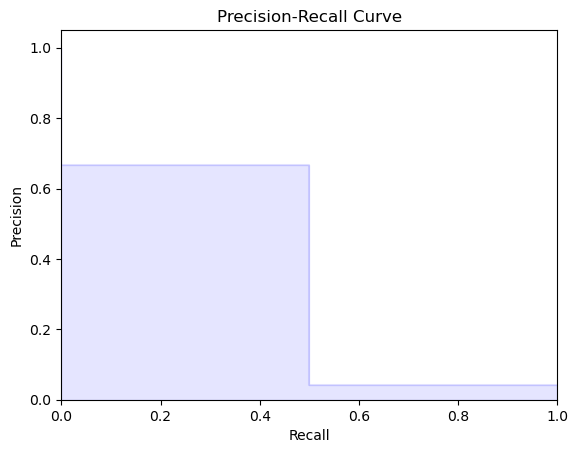

In [77]:
average_precision = average_precision_score(y_test, pred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))


precision, recall, _ = precision_recall_curve(y_test, pred)

step_kwargs = ({'step':'post'} if 'step' in signature(plt.fill_between).parameters else{})

plt.step(recall, precision, color='b', alpha=.1, where='post')

plt.fill_between(recall, precision, alpha=.1, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0,1.05])
plt.xlim([0.0,1.0])

plt.title('Precision-Recall Curve'.format(average_precision))

plt.show()

In [66]:
#ADDS THRESHOLD TO TRY AND IMPROVE RESULTS - Does not

threshold = 0.6
predicted_proba = rfr.predict_proba(X_test)
pred = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test, pred)
print('Accuracy of predictions with threshold:')
print(accuracy)

print('Confusion matrix with threshold:')
print(confusion_matrix(y_test,pred))


Accuracy of predictions with threshold:
0.9578947368421052
Confusion matrix with threshold:
[[91  0]
 [ 4  0]]


Average precision-recall score: 0.04


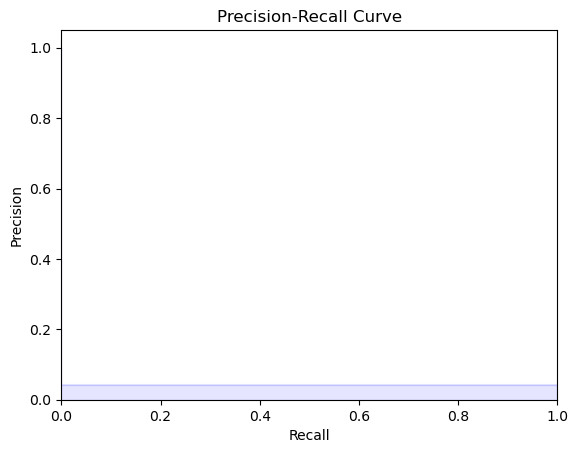

In [75]:
#Creates Precision Recall curve of thresholded algorithem:

average_precision = average_precision_score(y_test, pred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))


precision, recall, _ = precision_recall_curve(y_test, pred)

step_kwargs = ({'step':'post'} if 'step' in signature(plt.fill_between).parameters else{})

plt.step(recall, precision, color='b', alpha=.1, where='post')

plt.fill_between(recall, precision, alpha=.1, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0,1.05])
plt.xlim([0.0,1.0])

plt.title('Precision-Recall Curve'.format(average_precision))

plt.show()

In [90]:
#Last test, neural network, do cross validation to find optimal parameters
# define grid for max_depth
depth_grid = {'alpha': [.001,.002, .004, .006, .008, .01, .012, .014, .016 ,.018, .02 ]}
#grid_search = GridSearchCV(MLPClassifier(),depth_grid,cv=5,return_train_score=True)
#CV will run you through this number of groups. normally 5 or 10

#best_model=grid_search.fit(X_train,y_train)
print("Best alpha: ",best_model.best_estimator_.get_params()['alpha'])

# define grid for min_samples_split
#sample_grid = {'hidden_layer_sizes': [2, 4, 6, 8, 10, 15, 20, 30, 60, 100, 200]}
#grid_search = GridSearchCV(MLPClassifier(),sample_grid,cv=5,return_train_score=True)


#best_model=grid_search.fit(X_train,y_train)
print("Best hidden layer size: ",best_model.best_estimator_.get_params()['hidden_layer_sizes'])



Best alpha:  0.0001
Best hidden layer size:  4


In [96]:
mlp = MLPClassifier(alpha = .0001, hidden_layer_sizes= 4, random_state=42)
mlp.fit(X_train, y_train)
pred = mlp.fit(X_train, y_train).predict(X_test)
print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))
confusion_matrix(y_test,pred)


C:\Users\nicho\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1096: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nicho\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1096: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy on training set: 0.98
Accuracy on test set: 0.96


C:\Users\nicho\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


array([[91,  0],
       [ 4,  0]], dtype=int64)

Average precision-recall score: 0.04


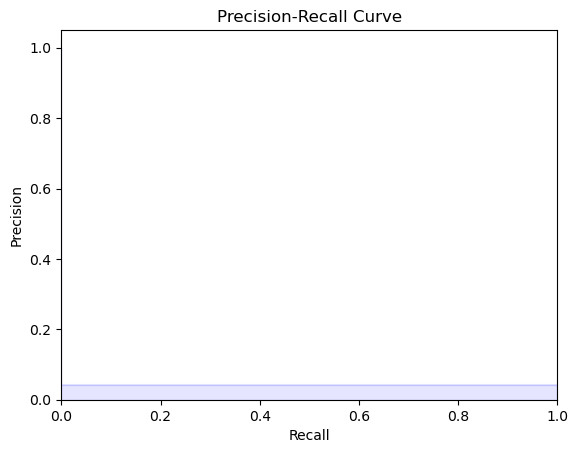

In [97]:
#Creates Precision Recall curve of thresholded algorithem:

average_precision = average_precision_score(y_test, pred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))


precision, recall, _ = precision_recall_curve(y_test, pred)

step_kwargs = ({'step':'post'} if 'step' in signature(plt.fill_between).parameters else{})

plt.step(recall, precision, color='b', alpha=.1, where='post')

plt.fill_between(recall, precision, alpha=.1, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0,1.05])
plt.xlim([0.0,1.0])

plt.title('Precision-Recall Curve'.format(average_precision))

plt.show()

The random forest model performs the best out of the models tested. 